In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, models, optimizers, regularizers, initializers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, HeUniform

2024-07-25 13:18:35.652341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 13:18:35.652507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 13:18:35.826620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
feature_extraction_model = load_model('/kaggle/input/fine-tuned-feature-extractor/fine_tuned_best_model.keras')
feature_extraction_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 27,861,829 (106.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,861,827 (106.28 MB)

 Optimizer params: 2 (12.00 B)

In [3]:
feature_extraction_model = Model(inputs=feature_extraction_model.input, outputs = feature_extraction_model.get_layer('global_max_pooling2d').output)
for layer in feature_extraction_model.layers:
    layer.trainable = False
    
feature_extraction_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
# Function to extract features from a list of image paths
def extract_features_from_paths(image_paths, model):
    features = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = model.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

# Function to extract features from a single image
def extract_features_from_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    feature = model.predict(img_array)
    return feature.flatten()


# Function to print class information
def print_class_info(path):
    classes = os.listdir(path)
    print("Found classes:")
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        num_images = len(os.listdir(class_path))
        print(f"  - {class_name}: {num_images} images")

In [5]:
import numpy as np

# Load the selected features
X_train = np.load('/kaggle/input/fined-tuned-no-gpu-vgg16-boruta/X_train_selected.npy')  # Training features
X_val = np.load('/kaggle/input/fined-tuned-no-gpu-vgg16-boruta/X_val_selected.npy')      # Validation features
X_test = np.load('/kaggle/input/fined-tuned-no-gpu-vgg16-boruta/X_test_selected.npy')    # Test features

y_train = np.load('//kaggle/input/fined-tuned-no-gpu-vgg16-boruta/y_train.npy')    # Training labels
y_val = np.load('/kaggle/input/fined-tuned-no-gpu-vgg16-boruta/y_val.npy')        # Validation labels
y_test = np.load('/kaggle/input/fined-tuned-no-gpu-vgg16-boruta/y_test.npy')      # Test labels

# Print shapes to verify
print("Validation features shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Training features shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train)
print(X_val)
print(X_test)
joblib.dump(scaler, 'scaler.pkl')

Validation features shape: (760, 282)
Validation labels shape: (760,)
Training features shape: (5329, 282)
Training labels shape: (5329,)
Test features shape: (384, 282)
Test labels shape: (384,)
[[-0.57542086 -0.6425264   1.619605   ... -0.01883043  0.44061062
  -0.38586247]
 [ 0.04552769 -0.6425264   0.12169423 ... -0.45196626 -0.1928281
  -0.38586247]
 [ 0.27075988 -0.6425264   1.431495   ... -0.24597101 -0.17930107
  -0.38586247]
 ...
 [ 2.3132696  -0.550432   -0.4143676  ...  1.0260643  -0.585136
  -0.38586247]
 [ 0.8140047   2.2035651  -0.82002294 ... -0.93503153 -0.585136
  -0.38586247]
 [-0.2337771  -0.6425264   2.7919343  ... -0.93503153  0.3863508
  -0.38586247]]
[[-3.5813937e-04 -6.4252639e-01  5.1683497e-01 ... -1.4015448e-01
   7.2808191e-02 -3.8586247e-01]
 [-6.8501514e-01 -1.3429451e-01  1.7320472e+00 ... -4.6469069e-01
   6.7434438e-02  7.1421969e-01]
 [ 2.1451755e-01  5.0417387e-01  5.7606161e-02 ...  2.4234607e+00
  -6.6352688e-02  7.5783783e-01]
 ...
 [-6.0640830e-01

['scaler.pkl']

In [6]:
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras import regularizers

# Define the optimizer
optimizer = Adadelta(learning_rate=0.01, rho=0.85, epsilon=1e-07)

# Define the kernel initializer
kernel_initializer = GlorotUniform()

# Define the L2 weight decay regularizer
l1_l2_regularizer = regularizers.l1_l2(l1=0.005, l2=0.005)

# Define the input layer
inputs = Input(shape=(X_train.shape[1],))

# Add first Dense layer
x = Dense(2048, kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2_regularizer)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Add second Dense layer
x = Dense(864, activation='relu', kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2_regularizer)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Add output layer
outputs = Dense(3, activation='softmax', kernel_initializer=kernel_initializer)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 282)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       579,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 864)            │     1,770,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 864)            │         3,456 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         2,595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,364,163 (9.02 MB)

 Trainable params: 2,358,339 (9.00 MB)

 Non-trainable params: 5,824 (22.75 KB)

Epoch 1/10000
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4944 - loss: 283.4231
Epoch 1: val_accuracy improved from -inf to 0.78906, saving model to best_model_accuracy.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.4981 - loss: 283.3802 - val_accuracy: 0.7891 - val_loss: 280.4123
Epoch 2/10000
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7073 - loss: 279.7373
Epoch 2: val_accuracy improved from 0.78906 to 0.80990, saving model to best_model_accuracy.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7079 - loss: 279.6939 - val_accuracy: 0.8099 - val_loss: 276.5963
Epoch 3/10000
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7385 - loss: 275.8134
Epoch 3: val_accuracy improved from 0.80990 to 0.83333, saving model to best_model_accuracy.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7387 - loss: 275.7900 - val_accuracy: 0.8333 - val_loss: 272.4309
Epoch 4/10000
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7662 - loss

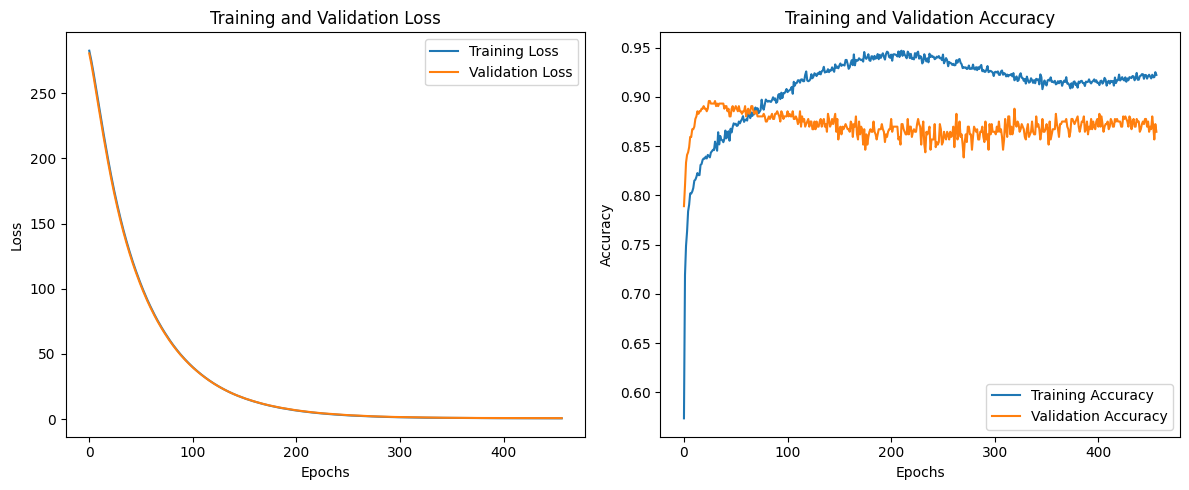

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.8958333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87       129
           1       0.85      0.88      0.86       129
           2       0.94      0.97      0.95       126

    accuracy                           0.90       384
   macro avg       0.90      0.90      0.90       384
weighted avg       0.90      0.90      0.90       384



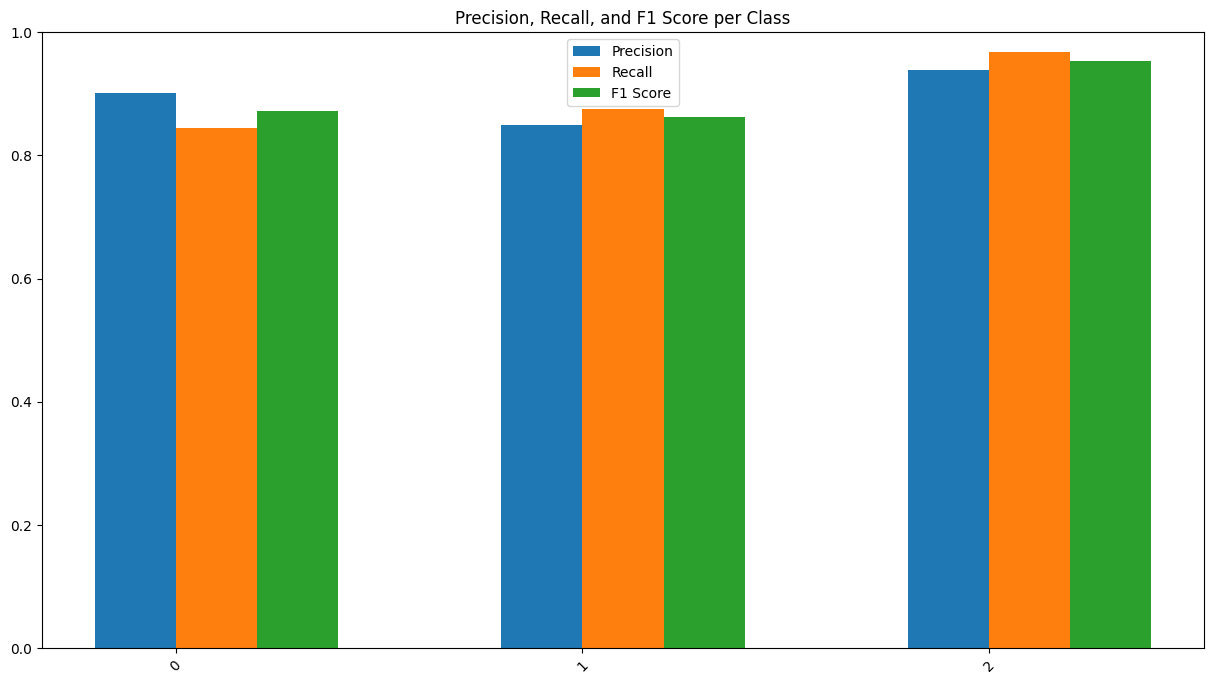

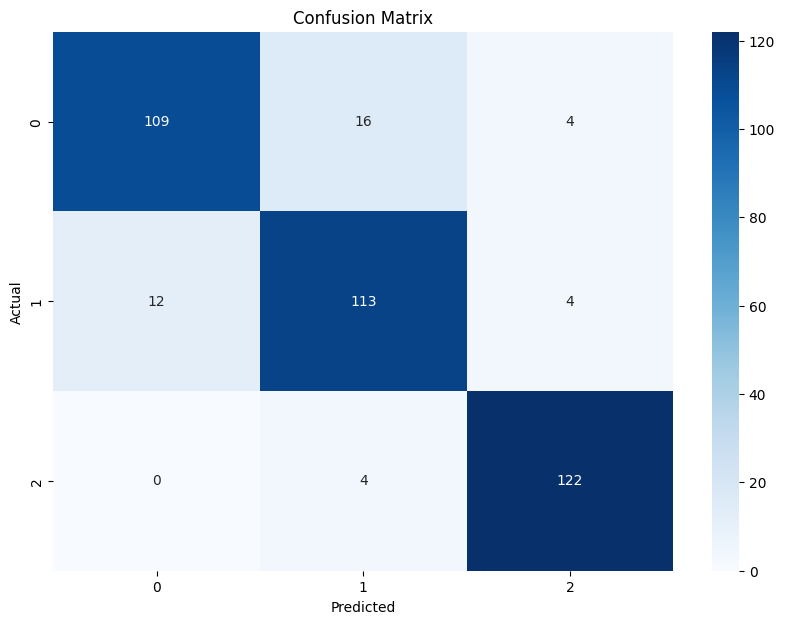

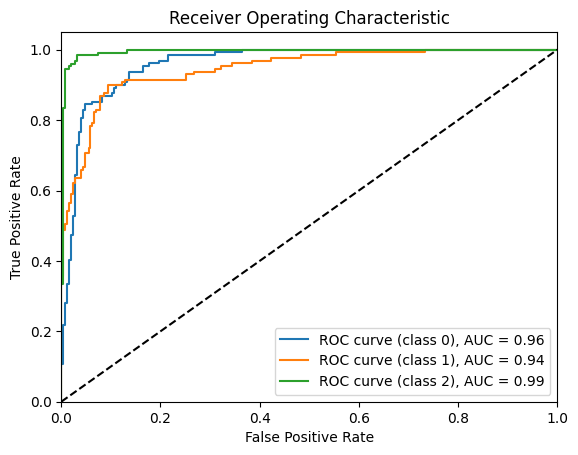

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_accuracy.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10000, 
                    batch_size=128, 
                    callbacks=[model_checkpoint, early_stopping])


# Plot loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accu
plt.subplot(1, 2, 2)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('training_validation_plot.jpeg', format='jpeg')

plt.tight_layout()
plt.show()


import os
import numpy as np
from keras.models import load_model
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt

# Load your trained model
model_test = load_model('/kaggle/working/best_model_accuracy.keras')

# Load the test features and labels
test_features = np.load('/kaggle/input/fined-tuned-no-gpu-vgg16-boruta/X_test_selected.npy')
test_labels = np.load('/kaggle/input/fined-tuned-no-gpu-vgg16-boruta/y_test.npy')

test_features = scaler.transform(test_features)

# Get class names from the test set directory
test_folder = '/kaggle/input/transparency-insured/New folder (2)/test'
class_names = sorted(os.listdir(test_folder))

# Make predictions
predictions = model_test.predict(test_features)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model
accuracy = accuracy_score(test_labels, predicted_classes)
report = classification_report(test_labels, predicted_classes, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Calculate Precision, Recall, F1 Score per class
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_classes, average=None)

# Create a bar graph
plt.figure(figsize=(15, 8))
class_names_list = list(class_names)  # Convert class_names to a list for indexing

# Set width for each bar (adjust as needed)
bar_width = 0.20

# Create bar positions for each metric
x_axis = np.arange(len(class_names))  # Positions for bars

# Plot Precision bars
plt.bar(x_axis - bar_width/2, precision, bar_width, label='Precision')

# Plot Recall bars (shifted to the right)
plt.bar(x_axis + bar_width/2, recall, bar_width, label='Recall')

# Plot F1 Score bars (shifted further to the right)
plt.bar(x_axis + 3*bar_width/2, f1, bar_width, label='F1 Score')

# Set x-axis labels with rotation
plt.xticks(x_axis, class_names_list, rotation=45)
plt.ylim(0, 1)  # Adjust y-axis limits as needed
plt.legend()
plt.title('Precision, Recall, and F1 Score per Class')
plt.savefig('precision recall and f1 score graph.jpeg', format='jpeg')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.jpeg', format='jpeg')
plt.show()

# Calculate ROC curve and AUC
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))
y_score = predictions

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {class_names[i]}), AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('AUCROC.jpeg', format='jpeg')
plt.show()

